In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)
print(X.shape)

(200, 256, 256, 3)


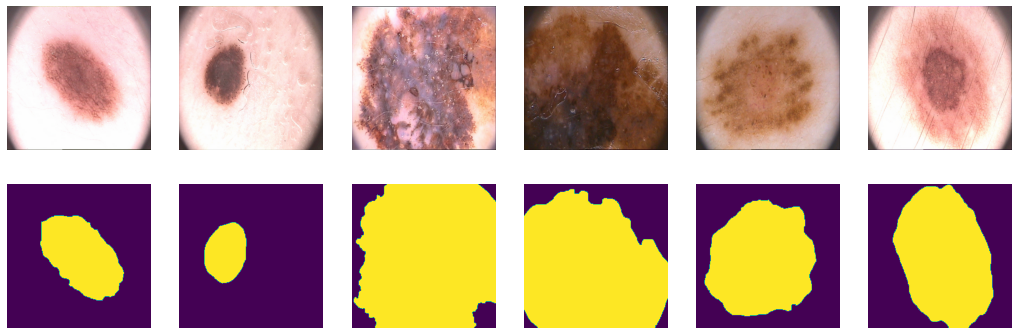

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


In [ ]:
from torch.utils.data import DataLoader
batch_size = 15
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from tqdm import tqdm

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        padding = 1
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)# 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)# 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)# 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(512)
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(256)
            )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)# 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=padding),
            nn.ReLU(),
            nn.BatchNorm2d(64)
            )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)# 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64 , out_channels=64, kernel_size=3, padding=padding),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64 , out_channels=1, kernel_size=3, padding=padding),
            nn.BatchNorm2d(1)
            )

    def forward(self, x):
        # encoder
        # print(f'x: {x.shape}')
        e0, ind0 = self.pool0(self.enc_conv0(x))
        # print(f'e0: {e0.shape}, ind0: {ind0.shape}')
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        # print(f'e1: {e1.shape}, ind1: {ind1.shape}')
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        # print(f'e2: {e2.shape}, ind2: {ind2.shape}')
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        # print(f'e3: {e3.shape}, ind3: {ind3.shape}')

        # bottleneck
        b, ind_b = self.bottleneck_pool(self.bottleneck_conv(e3))
        b = self.bottleneck_upsample(b, ind_b)
        # print(f'b: {b.shape}')
        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        # print(f'd0: {d0.shape}')
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        # print(f'd1: {d1.shape}')
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        # print(f'd2: {d2.shape}')
        d3 = self.dec_conv3(self.upsample2(d2, ind0))
        print(f'd3: {d3.shape}') # no activation
        return d3

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou

In [ ]:
def bce_loss(y_real, y_pred):#y_real = target, y_pred = model_outputs
    y_pred_mean = y_pred.view(-1)
    y_real_mean = y_real.view(-1)
    intersection = (y_pred_mean * y_real_mean).mean()
    param = 1 + torch.exp(-torch.abs(y_pred_mean))
    bce = max(0, y_pred_mean.mean()) - intersection + torch.log(param)
    return bce.mean()

In [ ]:
def train_model(model, opt, loss_fn, epochs, data_tr, data_val):
    for epoch in range(epochs):

      avg_loss = 0
      for X_batch, Y_batch in tqdm(data_tr):
        model.train()
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        # set parameter gradients to zero
        opt.zero_grad()
        # forward
        outputs = model(X_batch)
        loss = loss_fn(outputs, Y_batch)# forward-pass
        loss.backward()  # backward-pass
        opt.step()
        avg_loss += loss / len(data_tr)
        # preds = torch.argmax(outputs, 1)
      
      for X_val, Y_val in tqdm(data_val):
        model.eval()
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)
        with torch.no_grad():
          outputs = model(X_val).cpu()
      clear_output(wait=True)
      for k in range(6):
          plt.subplot(2, 6, k+1)
          plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
          plt.title('Real')
          plt.axis('off')

          plt.subplot(2, 6, k+7)
          plt.imshow(outputs[k, 0], cmap='gray')
          plt.title('Output')
          plt.axis('off')
      plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
      plt.show()

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    history = []
    val_loss = []
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      for epoch in range(epochs):
          tic = time()
          print('* Epoch %d/%d' % (epoch+1, epochs))

          avg_loss = 0
          avg_loss_val = 0
          model.train()  # train mode
          for data in tqdm(data_tr, leave=False, desc="batch_iter"):
              X_batch, Y_batch = data
              # data to device
              print(f'X_batch: {X_batch.shape}, Y_batch: {Y_batch.shape}')
              X_batch = X_batch.to(device)
              Y_batch = Y_batch.to(device)
              # set parameter gradients to zero

              opt.zero_grad()
              # forward

              Y_pred = model(X_batch)
              print(Y_pred.shape)
              loss = loss_fn(Y_pred, Y_batch)# forward-pass
              loss.backward()  # backward-pass
              opt.step()  # update weights
              # calculate loss to show the user
              avg_loss += loss / len(data_tr)
          toc = time()
          history.append(avg_loss)
          print('loss: %f' % avg_loss)

          # show intermediate results
          model.eval()
          with torch.no_grad():
            for data_v in tqdm(data_val, leave=False, desc="Val_data+batch"):
              X_batch_val, Y_batch_val = data_v
              X_batch_val = X_batch_val.to(device)
              Y_batch_val = Y_batch_val.to(device)
              Y_hat = model(X_batch_val)              # testing mode# detach and put into cpu
              loss = loss_fn(Y_hat, Y_batch_val)
              avg_loss_val += loss / len(data_val)
            
            val_loss.append(avg_loss_val)
            Y_hat = model(X_val.to(device)).cpu()
          # Visualize tools
          clear_output(wait=True)
          for k in range(6):
              plt.subplot(2, 6, k+1)
              plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
              plt.title('Real')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(Y_hat[k, 0].detach().numpy(), cmap='gray')
              plt.title('Output')
              plt.axis('off')
          plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
          plt.show()
      pbar_outer.update(1)
      tqdm.write(f'Epoch: {epoch + 1}\t avg_loss: {avg_loss}')
      return history, val_loss

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    scores_list = []
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        scores += metric((torch.sigmoid(Y_pred) > 0.5), Y_label.to(device)).mean().item()
        scores_list.append(scores)

    return scores / len(data) , scores_list

In [ ]:
model = SegNet().to(device)

In [ ]:
max_epochs = 40
optim = torch.optim.AdamW(model.parameters())
train_loss, val_loss = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

* Epoch 1/40



batch_iter:   0%|          | 0/7 [00:00<?, ?it/s]

X_batch: torch.Size([15, 3, 256, 256]), Y_batch: torch.Size([15, 1, 256, 256])
d3: torch.Size([15, 1, 256, 256])
torch.Size([15, 1, 256, 256])



batch_iter:  14%|█▍        | 1/7 [00:02<00:13,  2.30s/it]

X_batch: torch.Size([15, 3, 256, 256]), Y_batch: torch.Size([15, 1, 256, 256])
d3: torch.Size([15, 1, 256, 256])
torch.Size([15, 1, 256, 256])



batch_iter:  29%|██▊       | 2/7 [00:03<00:08,  1.61s/it]

X_batch: torch.Size([15, 3, 256, 256]), Y_batch: torch.Size([15, 1, 256, 256])
d3: torch.Size([15, 1, 256, 256])
torch.Size([15, 1, 256, 256])



batch_iter:  43%|████▎     | 3/7 [00:04<00:05,  1.47s/it]

X_batch: torch.Size([15, 3, 256, 256]), Y_batch: torch.Size([15, 1, 256, 256])



epoch:   0%|          | 0/40 [00:05<?, ?it/s]


KeyboardInterrupt: ignored

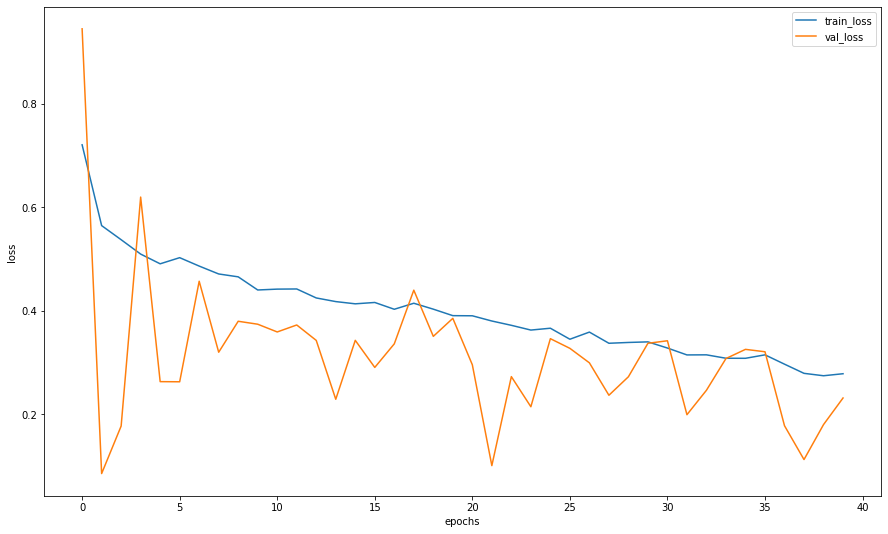

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
score_bce, score_list = score_model(model, iou_pytorch, data_val)
score_list
score_bce

0.7836411148309708

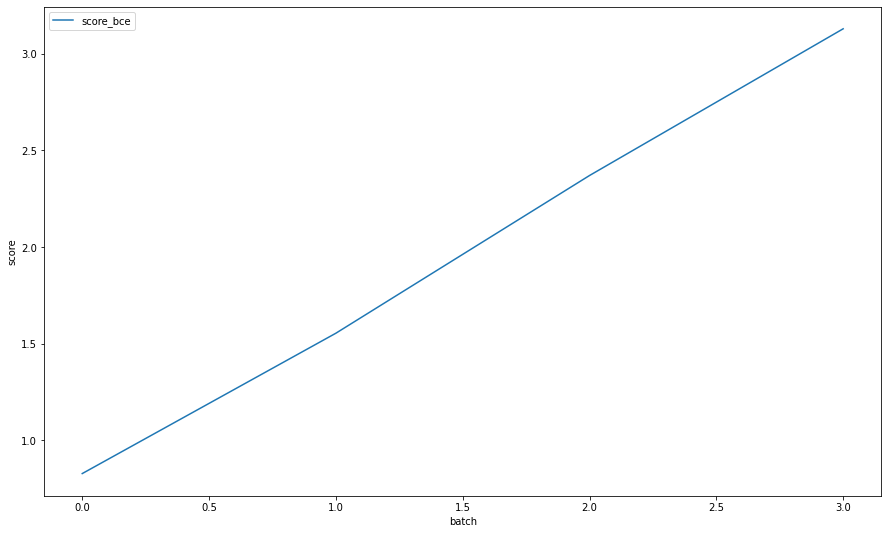

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_list, label="score_bce")
plt.legend(loc='best')
plt.xlabel("batch")
plt.ylabel("score")
plt.show()

In [ ]:
coef = round((1 / (256 * 256)), 7)

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = 2 * torch.sum(y_pred * y_real)
    den = torch.sum(y_real + y_pred)
    res = 1 - (num / den).mean()
    return res

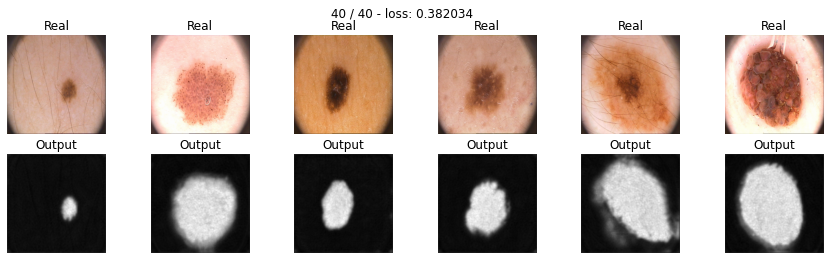

epoch:   2%|▎         | 1/40 [07:39<4:58:49, 459.72s/it]

Epoch: 40	 avg_loss: 0.38203370571136475


In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.AdamW(model_dice.parameters())
train_dice_loss, val_dice_loss = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

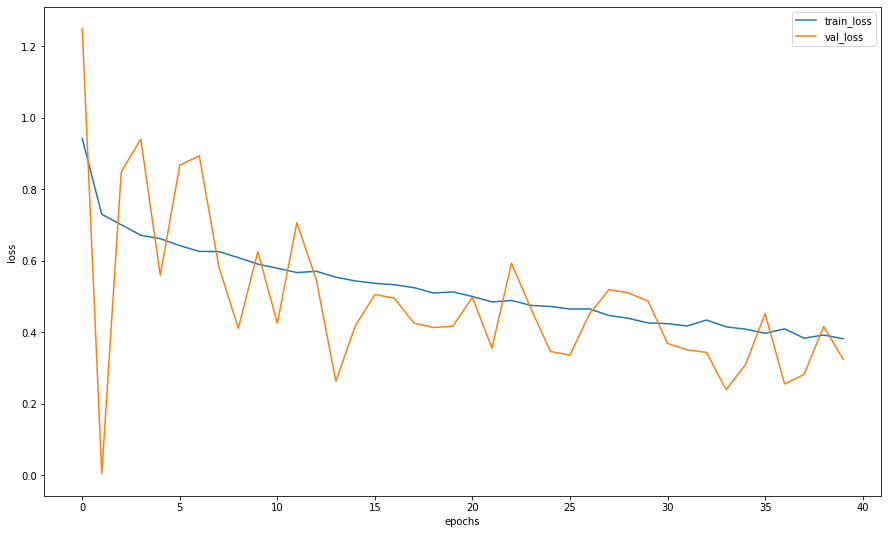

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_dice_loss, label="train_loss")
plt.plot(val_dice_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
score_dice, score_dice_list = score_model(model_dice, iou_pytorch, data_val)
score_dice

0.7952065318822861

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    bce_part = bce_loss(y_real, y_pred)
    y_pred = torch.clamp(y_pred, eps, 1) # hint: torch.clamp
    focal_part = (1 - torch.sigmoid(y_pred))**gamma
    loss = (focal_part * bce_part).mean()
    return loss

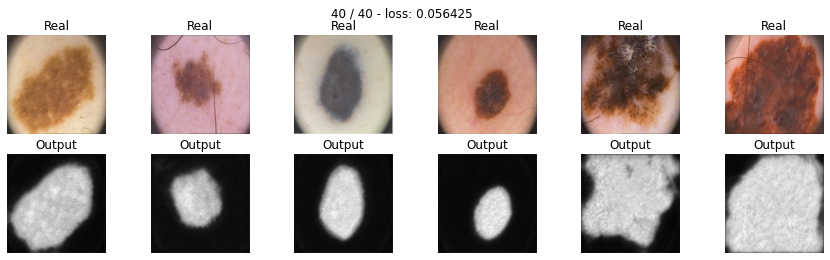

epoch:   2%|▎         | 1/40 [07:41<4:59:40, 461.05s/it]

Epoch: 40	 avg_loss: 0.056424710899591446


In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.AdamW(model_focal.parameters())
focal_train_loss, focal_val_loss = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
focal_score, focal_score_hist = score_model(model_focal, iou_pytorch, data_val)
focal_score

0.7741994708776474

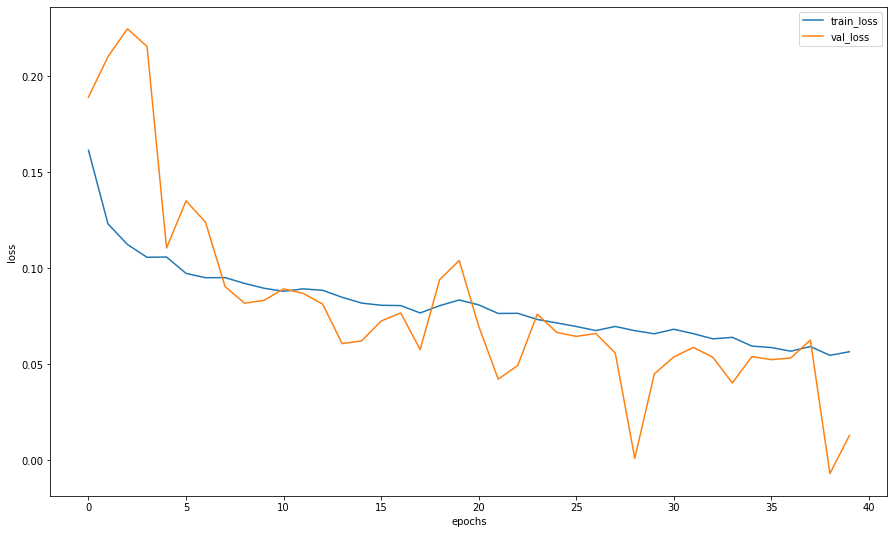

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(focal_train_loss, label="train_loss")
plt.plot(focal_val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()